In [49]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
%matplotlib inline
import random
plt.rcParams.update({"font.size" : 14})
plt.rcParams.update({"axes.labelsize" : 14})

## Some functions to read in the models

The read_track will read a whole MESA file.

The read_track small will only read the columns that are used in the code below,
allowing for the code to run faster, with less memory usage. 

In [2]:
def read_track(file):
    data = np.genfromtxt( file, skip_header=5, names=True)
    return (data)

def read_track_small(file):
    col  = [1,6,11,12,54,75]
    data = np.genfromtxt( file, skip_header=5, usecols=col, names=True)
    return (data)

The little bit of code below was just to test that
the right columns were indeed read in the MESA file.

In [5]:
data = read_track_small(r'D:\Summer2021\Magneticf\1kG\M5Z14B1.data')

In [6]:
a = data.dtype
for i, item in enumerate(a.names):
    print(i, item)

0 star_age
1 log_Teff
2 log_L
3 log_R
4 center_h1
5 Bp


# 1. Initial Mass Funciton illustration for the poster

$$ N=\displaystyle\epsilon_0\int_{M_1}^{M_2}{M^{-\alpha}}\mathrm{d}M $$

$$ N =\frac{\epsilon_0}{1 - \alpha} M^{1 - \alpha} \Biggr|_{M_1}^{M_2} $$

$$ N =  \frac{\epsilon_0}{ 1 - \alpha} (M_2^{1- \alpha} - M_1^{1 - \alpha}) $$

-  $\alpha = 2.35$ (Salpeter Initial Mass Function)
- $\epsilon_0 = 5820$ For 100 stars

There are 6.0 stars in the most massive bin
There are 100.0 stars in the cluster
['36.0', '32.0', '14.0', '12.0', '6.0']


(0, 40)

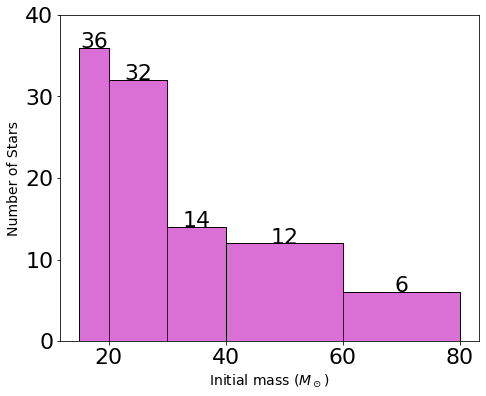

In [31]:
#This would be for uniform bin distribution
#delta_M=5 
#start=5 
#stop=60 
#M_1= np.arange(start, stop+(delta_M/2), delta_M)
#M_2= np.arange(start+delta_M, stop+delta_M+(delta_M/2), delta_M)

# This is for the masses for which we have models for
M_1 = np.array([ 15, 20, 30, 40, 60 ])
M_2 = np.array([ 20, 30, 40, 60, 80 ])
M_width = M_2 - M_1

alpha=2.35 # Using Salpeter IMF
#epsilon_0=2860 # For 50 stars
epsilon_0=5820 # For 100 stars

N= np.round((epsilon_0/(1-alpha))*(M_2**(1-alpha)-M_1**(1-alpha)))

print('There are {} stars in the most massive bin'.format(N[-1]))
print('There are {} stars in the cluster'.format(np.sum(N)))

fig, ax = plt.subplots(1,1, figsize=(15/2,6))
plt.rcParams.update({'font.size': 22})
#ax.scatter(M_1, N)
ax.set_xlabel('Initial mass ($M_\odot$)')
ax.set_ylabel('Number of Stars')
#ax.set_title('Stars Probability Distribution by Initial Mass Function(IMF)')

ax.bar(M_1, N, width=M_width, align='edge', color='orchid', edgecolor = 'k')
print(['{}'.format(x) for x in N])

for i in range(0, M_1.size):
    ax.text(M_1[i]+M_width[i]/2, N[i], '{:0.0f}'.format(N[i]), ha='center' )
    
ax.set_ylim(0,40)

#x = np.linspace(10,80)
#ax.plot(x, x**(-1*alpha)*epsilon_0)

# 2. Initial magnetic B-field function distribution

These are some notes on how to convert a set of uniformally distributed random values (between 0 and 1) into a set of random values distributed according to a powerlaw distribution bounded between $B_\mathrm{min}$ and $B_\mathrm{max}$.

The final equation is used in the power-law function defined in the next cells.

I want a power law statistical distribution

$$ P = \frac{ B^{-\alpha_B} }{ \int B^{-\alpha_B}dB }  $$


$$ P = \frac{ B^{-\alpha_B}}{ \frac{1}{{1-\alpha_B}}(B_\mathrm{max}^{1-\alpha_B} -B_\mathrm{min}^{1-\alpha_B})}  $$

$$ P = \frac{1}{N} B^{-\alpha_B} $$

where $N$ is the normalization factor. 

From this normalized probability density, we can find the cummulative distribution of probability:

$$ C(B) = \int_0^B P(B)dB $$

which is bounded between zero and one in the interval $B=[B_\mathrm{min}, B_\mathrm{max}]$.

Thus:

$$C(B) = \frac{1}{N}\int_{B_\mathrm{min}}^{B_\mathrm{max}} B^{-\alpha} dB$$


$$C(B) = \frac{1}{N} \frac{1}{1-\alpha_B} \left[B^{1-\alpha_B} - B_\mathrm{min}^{1-\alpha_B}\right]$$

$$C(B) =  \frac{1}{(B_\mathrm{max}^{1-\alpha_B} -B_\mathrm{min}^{1-\alpha_B})} \left[B^{1-\alpha_B} - B_\mathrm{min}^{1-\alpha_B}\right]$$


Now we can invert this cummulative function for $B$ such that:

$$B(C) = \left[ (B_\mathrm{max}^{1-\alpha_B} - B_\mathrm{min}^{1-\alpha_B})C + B_\mathrm{min}^{1-\alpha_B} \right]^{1/(1-\alpha)} $$

And now, if I generate a set of uniformly distributed random values between 0 and 1 as $C$ in the above equation, I will get a set of random values for $B$ distributed according to $P(B)$ (the power law at the top). 

## Functions that will determine magnetic field values according to the uniform or the powerlaw function



In [32]:
def get_B_uni(N, model_B_array = np.array([0, 1, 5, 10, 20]), Bmax=30.0):

    ### The model_B_array represent the lower edge of the magnetic field bins. 
    ### Bmax is the higher edge of the last bin
    
    B_bins = np.append(model_B_array, Bmax-0.01)
    B_dist = np.random.random_sample(int(N))*Bmax
    B_binned, edges = np.histogram(B_dist, bins=B_bins)
    
    return(B_binned)

def get_B_pow(N, model_B_array = np.array([0, 1, 5, 10, 20]), Bmin = 0.01, Bmax = 30.0, alphaB = 0.8 ):
    
    ### The model_B_array represent the lower edge of the magnetic field bins. 
    ### Default values in kG
    ## Bmin = 0.01
    ## Bmax = 30.0
    ### Default values for the powerlaw index
    ### alphaB = 0.8
             
    C = np.random.random(int(N))
    B_pow_rand = ( (Bmax**(1-alphaB)-Bmin**(1-alphaB))*C + Bmin**(1-alphaB) )**(1/(1-alphaB))

    B_bins = np.append(model_B_array, Bmax-0.01)
    B_binned, edges = np.histogram(B_pow_rand, bins=B_bins)
    
    return(B_binned)

## Illustration of the magnetic field distributions for the poster

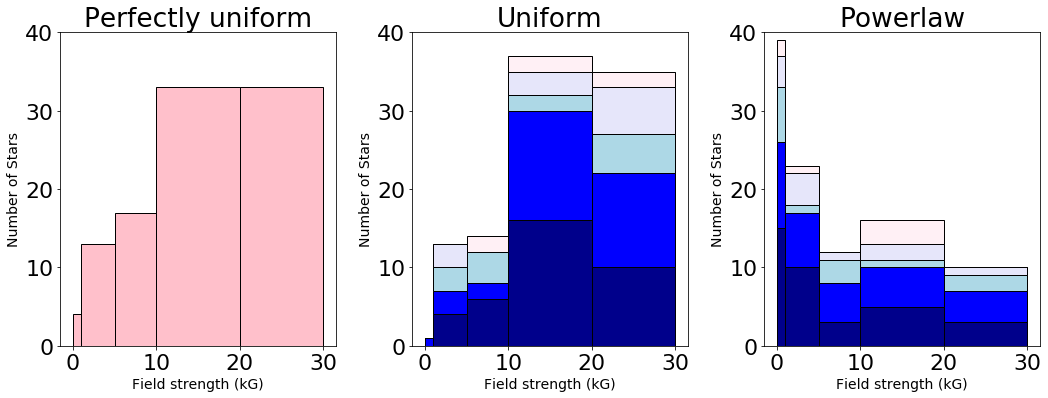

In [33]:
fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.rcParams.update({'font.size': 22})
for item in ax:
    item.set_xlabel('Field strength (kG)')
    item.set_ylabel('Number of Stars')

ax[0].set_title('Perfectly uniform')
ax[1].set_title('Uniform')
ax[2].set_title('Powerlaw')

for item in ax:
    item.set_ylim(0,40)
    
model_B_array = np.array([0, 1, 5, 10, 20])
B_bins = np.append(model_B_array, 29.99)

B_uniform = np.linspace(0, 29.99, 100)
#print(B_uniform)
B_binned, edges = np.histogram(B_uniform, bins=B_bins)
#print(B_binned)
ax[0].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], bottom=0, align='edge', color='pink', edgecolor = 'k')
#print(np.sum(B_binned))

mass_color = ['darkblue', 'blue', 'lightblue', 'lavender', 'lavenderblush']
B_binned_total = np.zeros(model_B_array.size)
for item, color in zip(N, mass_color):
    #print(item)

    B_binned = get_B_uni(item)
    #print(B_binned)
    ax[1].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], 
              bottom=B_binned_total, align='edge', color=color, edgecolor = 'k')
    B_binned_total = B_binned_total + B_binned

B_binned_total = np.zeros(model_B_array.size)
for item, color in zip(N, mass_color):
    #print(item)

    B_binned = get_B_pow(item)
    #print(B_binned)
    ax[2].bar(model_B_array, B_binned, width=B_bins[1:]-B_bins[0:-1], 
              bottom=B_binned_total, align='edge', color=color, edgecolor = 'k')
    B_binned_total = B_binned_total + B_binned

plt.tight_layout()

# 3. The code below was used to create the illustration of a single Cluster Simulation, for illustration in the poster. 

### This part calculate the needed values, and save them in the file.

The file name can be changed at the bottom of the cell.

To switch between the uniform or powerlaw calculation, the following line can be changed:

    B_binned = get_B_pow(N[i])

or

    B_binned = get_B_uni(N[i])

There are 36.0 stars of 15 Msun
  And their field values are [11 14  4  5  2]
D:\Summer2021\Magneticf\M15Z14B0.data
D:\Summer2021\Magneticf\M15Z14B1.data
D:\Summer2021\Magneticf\M15Z14B5.data
D:\Summer2021\Magneticf\M15Z14B10.data
D:\Summer2021\Magneticf\M15Z14B20.data
There are 32.0 stars of 20 Msun
  And their field values are [13 11  3  2  3]
D:\Summer2021\Magneticf\M20Z14B0.data
D:\Summer2021\Magneticf\M20Z14B1.data
D:\Summer2021\Magneticf\M20Z14B5.data
D:\Summer2021\Magneticf\M20Z14B10.data
D:\Summer2021\Magneticf\M20Z14B20.data
There are 14.0 stars of 30 Msun
  And their field values are [9 4 1 0 0]
D:\Summer2021\Magneticf\M30Z14B0.data
D:\Summer2021\Magneticf\M30Z14B1.data
D:\Summer2021\Magneticf\M30Z14B5.data
There are 12.0 stars of 40 Msun
  And their field values are [6 0 2 2 2]
D:\Summer2021\Magneticf\M40Z14B0.data
D:\Summer2021\Magneticf\M40Z14B5.data
D:\Summer2021\Magneticf\M40Z14B10.data
D:\Summer2021\Magneticf\M40Z14B20.data
There are 6.0 stars of 60 Msun
  And their fie

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


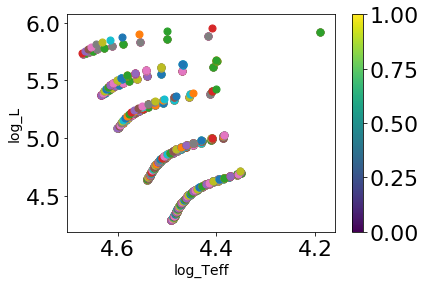

In [45]:
fig, ax = plt.subplots(1,1)


# This is for the masses for which we have models for
M_1 = np.array([ 15, 20, 30, 40, 60 ])
M_2 = np.array([ 20, 30, 40, 60, 80 ])
M_width = M_2 - M_1

alpha=2.35 # Using Salpeter IMF
#epsilon_0=2860 # For 50 stars
epsilon_0=5820 # For 100 stars

N= np.round((epsilon_0/(1-alpha))*(M_2**(1-alpha)-M_1**(1-alpha)))

model_B_array = np.array([0, 1, 5, 10, 20])

age=np.linspace(0.5,15, 50)*1e6 

B_limit = 500.0

detected = np.zeros( (age.size, M_1.size) )

N_real = np.zeros( (age.size, M_1.size) ) # array to keep track of the number of stars (to account for stars off the MS)

ms_criteria = 0.01

for i in range(0, N.size):
    
    if N[i]>0:
        print('There are {} stars of {} Msun'.format(N[i], M_1[i]))
        
        ########################
        # This is the line to change to switch from powerlaw to uniform.
        ########################        
        B_binned = get_B_pow(N[i])
        ########################        
        ########################        
        
        print('  And their field values are {}'.format(B_binned))
    
        for j in range(0, model_B_array.size ):
            
            if B_binned[j]>0:
        
                name = r'D:\Summer2021\Magneticf\M{:0.0f}Z14B{:0.0f}.data'.format( M_1[i], model_B_array[j]  )
                print(name)
    
                data = read_track_small(name)
                # Cut the tracks to the MS
                ms=np.where(data['center_h1']>ms_criteria)
                data = data[ms]
                
                for k in range(0,age.size):
                    n=np.where(data['star_age']>=age[k])
                    if n[0].size>0:
                        N_real[k,i] = N_real[k,i]+ B_binned[j] # Still on the MS, add to the tally. 
                        if data['Bp'][n[0][0]] >= B_limit:
                            detected[k,i] = detected[k,i] + B_binned[j]
                            
                        for item in range(0,B_binned[j]): # there are B_binned[j] stars with that field strength
                            #print(n[0][0])
                            #print(data['Bp'])
                            #print(data['log_Teff'][n[0][0]])
                            #print(data['log_L'][n[0][0]])
                            vero=ax.scatter(data['log_Teff'][n[0][0]], data['log_L'][n[0][0]], 
                                         cmap='plasma', vmin=0, vmax=2e4, s=50)
                        


ax.invert_xaxis()    
ax.set_xlabel('log_Teff')
ax.set_ylabel('log_L')
plt.colorbar(vero)

print( np.sum(N_real, axis=1) )
print( np.sum(detected, axis=1) )
print(  np.sum(detected, axis=1)/np.sum(N_real, axis=1))


np.save('UNI_500G_MC01_detect', detected)
np.save('UNI_500G_MC01_Nreal', N_real)
np.save('UNI_500G_MC01_age', age)


### The code below reads in the results written by the previous cell (the load statements)

and create the illustration plot that we used in the poster. 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


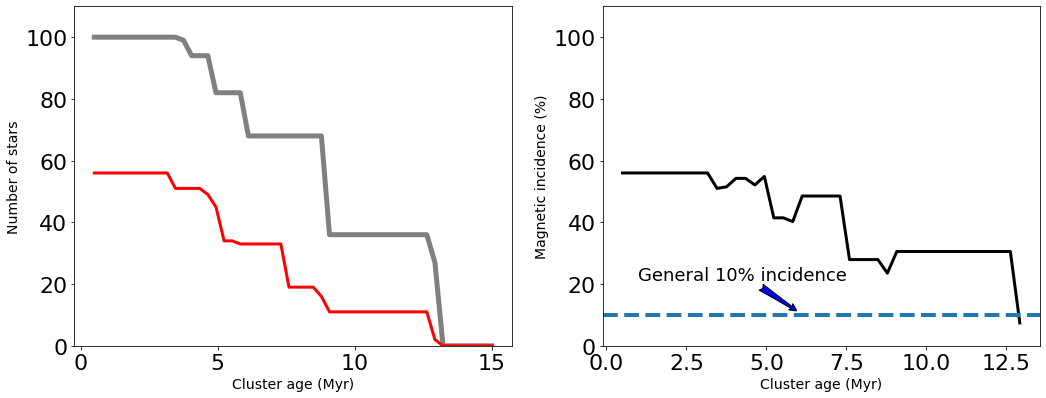

In [46]:
detected = np.load('UNI_500G_MC01_detect.npy')
N_real = np.load('UNI_500G_MC01_Nreal.npy')
age = np.load('UNI_500G_MC01_age.npy')


fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.rcParams.update({'font.size': 22})

ax[0].plot(age/1e6, np.sum(N_real, axis=1), label='MS stars', lw=5, c='0.5')
#ax.scatter(age/1e6, np.sum(N_real, axis=1), zorder=2000)

ax[0].plot(age/1e6, np.sum(detected, axis=1), label='Detected stars', lw=3, c='red')

ax[1].plot(age/1e6, np.sum(detected, axis=1)/np.sum(N_real, axis=1)*100, lw=3, c='k', label='Magnetic fraction infered')

ax[1].axhline(y=10, ls='--', lw=4)


#ax[0].annotate('Stars past the MS\nare not in the\nsimulated survey', xy=(8, 70), xytext=(10, 80),
#            arrowprops=dict(facecolor='0.5', arrowstyle='fancy'),
#            verticalalignment='top', horizontalalignment='left')


ax[1].annotate('General 10% incidence', xy=(6, 11), xytext=(1, 20),
            arrowprops=dict(facecolor='blue', arrowstyle='fancy'),
            verticalalignment='bottom', horizontalalignment='left',
               fontsize=18
              )


ax[0].set_ylabel('Number of stars')
ax[1].set_ylabel('Magnetic incidence (%)')
for item in ax:
    item.set_ylim(0,110)    
    item.set_xlabel('Cluster age (Myr)')
    
    
#ax[0].legend(loc=0, fontsize=18)

plt.tight_layout()

# 4. Main calculation loop.

The code below is the part that makes the full calculations. 

It writes the results in files (names can be changed at the end of the cell). 

To switch between the uniform or powerlaw calculation, the following line can be changed:

    B_binned = get_B_pow(N[i])

or

    B_binned = get_B_uni(N[i])

In [47]:
# This is for the masses for which we have models for
M_1 = np.array([ 15, 20, 30, 40, 60 ])
M_2 = np.array([ 20, 30, 40, 60, 80 ])
M_width = M_2 - M_1

alpha=2.35 # Using Salpeter IMF
#epsilon_0=2860 # For 50 stars
epsilon_0=5820 # For 100 stars

N= np.round((epsilon_0/(1-alpha))*(M_2**(1-alpha)-M_1**(1-alpha)))

model_B_array = np.array([0, 1, 5, 10, 20])

age=np.linspace(0.5,15, 50)*1e6 

B_limit = 500
ms_criteria = 0.01

n_MC = 50

detected = np.zeros( (age.size, M_1.size, n_MC) )

N_real = np.zeros( (age.size, M_1.size, n_MC) ) # array to keep track of the number of stars (to account for stars off the MS)


for MC in range(0,n_MC):
    print(MC)
    for i in range(0, N.size):
        if N[i]>0:
            ########################
            # This is the line to change to switch from powerlaw to uniform.
            ########################        
            B_binned = get_B_uni(N[i])
            ########################        
            ########################        

            for j in range(0, model_B_array.size ):

                if B_binned[j]>0:

                    name = r'D:\Summer2021\Magneticf\M{:0.0f}Z14B{:0.0f}.data'.format( M_1[i], model_B_array[j]  )
                    data = read_track_small(name)
                    # Cut the tracks to the MS
                    ms=np.where(data['center_h1']>ms_criteria)
                    data = data[ms]

                    for k in range(0,age.size):
                        n=np.where(data['star_age']>=age[k])
                        if n[0].size>0:
                            N_real[k,i, MC] = N_real[k,i, MC]+ B_binned[j] # Still on the MS, add to the tally. 
                            if data['Bp'][n[0][0]] >= B_limit:
                                detected[k,i,MC] = detected[k,i,MC] + B_binned[j]
                        



#np.save('POW_500G_MC50_detect', detected)
#np.save('POW_500G_MC50_Nreal', N_real)
#np.save('POW_500G_MC50_age', age)
np.save('UNI_500G_MC50_detect', detected)
np.save('UNI_500G_MC50_Nreal', N_real)
np.save('UNI_500G_MC50_age', age)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


### This cell reads in a set of calculations performed by the cell above

and makes the graphs. 

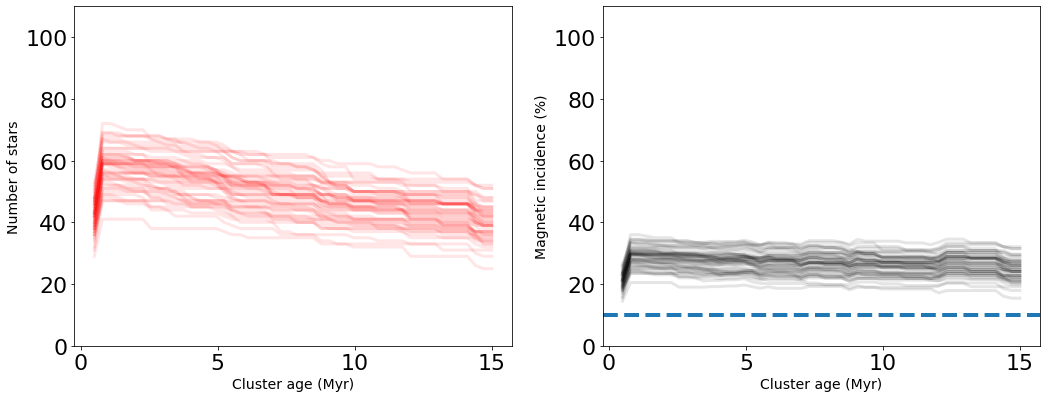

In [48]:
detected = np.load('POW_1.2_500G_MC50_detect.npy')
N_real = np.load('POW_1.2_500G_MC50_Nreal.npy')
age = np.load('POW_1.2_500G_MC50_age.npy')

n_MC = 50

fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.rcParams.update({'font.size': 22})

for MC in range(0,n_MC):
    ax[0].plot(age/1e6, np.sum(N_real[:,:,MC], axis=1), alpha=0.1,label='Number of MS stars', lw=3, c='0.5')
    ax[0].plot(age/1e6, np.sum(detected[:,:,MC], axis=1), alpha=0.1, label='Number of detected stars', lw=3, c='red')
    ax[1].plot(age/1e6, np.sum(detected[:,:,MC], axis=1)/np.sum(N_real[:,:,MC], axis=1)*100, alpha=0.1, c='k', label='Magnetic fraction infered',lw=3 )

ax[0].set_ylabel('Number of stars')
ax[1].set_ylabel('Magnetic incidence (%)')
for item in ax:
    item.set_ylim(0,110)    
    item.set_xlabel('Cluster age (Myr)')

ax[1].axhline(y=10, ls='--', lw=4)

    
plt.tight_layout()